# Deuteron electrodisintegration

_Last update:_ February 10, 2025

In [1]:
# Python imports
from functools import partial
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sympy.physics.quantum.cg import CG

In [2]:
# JAX imports
from jax import config, jit, vmap
import jax.numpy as jnp
from jax.numpy.linalg import eigh, solve
from jax.scipy.special import sph_harm, factorial
from jaxinterp2d import interp2d

In [3]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_channel
from scripts.integration import gaussian_quadrature_mesh
from scripts.tools import channel_L_value, coupled_channel, replace_periods

In [4]:
import jax
print(jax.__version__)

0.4.26


### Set-up

In [5]:
# Enable double precision
config.update("jax_enable_x64", True)

In [6]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Classes

In [7]:
class ClebschGordan:
    """
    Class for computing Clebsch-Gordan coefficients using SymPy to precompute
    and storing values in a JAX array for look-up. Note, we do not need to
    worry about half-integer values here.
    """
    
    def __init__(self, j_max):
        
        # Precompute the JAX array of Clebsch-Gordan coefficients
        self.cg_array = self.compute_clebsch_gordan_array(j_max)
        
        # Set j_max as an instance attribute
        self.j_max = j_max
    
    def compute_clebsch_gordan_array(self, j_max):
        """Calculate Clebsch-Gordan coefficients for combinations of j and m_j
        up to j_max.
        """
        
        # Initialize big JAX array
        ntot_j = j_max + 1
        ntot_m = 2 * ntot_j + 1
        cg_array = jnp.zeros((ntot_j, ntot_m, ntot_j, ntot_m, ntot_j, ntot_m))
        
        # Loop over quantum numbers and compute/store coefficients
        j_array = np.arange(0, j_max + 1, 1)
        m_array = np.arange(-j_max, j_max + 1, 1)
        for ij1, j_1 in enumerate(j_array):
            for im1, m_1 in enumerate(m_array):
                for ij2, j_2 in enumerate(j_array):
                    for im2, m_2 in enumerate(m_array):
                        for ij3, j_3 in enumerate(j_array):
                            for im3, m_3 in enumerate(m_array):
                                
                                # Check if the quantum numbers make sense
                                cond = self.is_physical(j_1, m_1, j_2, m_2, j_3,
                                                        m_3)
                                
                                # Value of coefficient will be zero otherwise
                                if cond:
                                    
                                    cg_array = (
                                        cg_array.at[
                                            ij1, im1, ij2, im2, ij3, im3
                                        ].set(
                                            float(
                                                CG(
                                                    j_1, m_1, j_2, m_2, j_3, m_3
                                                ).doit()
                                            )
                                        )
                                    )
                                    
        return cg_array
    
    def is_physical(self, j_1, m_1, j_2, m_2, j_3, m_3):
        """Check if quantum numbers make sense."""
        
        m_1_bool = self.check_projection(j_1, m_1)
        m_2_bool = self.check_projection(j_2, m_2)
        j_3_bool = np.abs(j_1 - j_2) <= j_3 <= j_1 + j_2
        m_3_bool = m_3 == m_1 + m_2 and self.check_projection(j_3, m_3)
        
        return m_1_bool and m_2_bool and j_3_bool and m_3_bool
    
    def check_projection(self, j, m_j):
        """Check if angular momentum projection is physical."""
        
        return np.abs(m_j) <= j

    @partial(jit, static_argnums=(0,))
    def get_coefficient(self, j_1, m_1, j_2, m_2, j_3, m_3):
        """Return the CG coefficient given input angular momentum."""
        
        # Values of j are the same as its index
        ij1, ij2, ij3 = j_1, j_2, j_3
        
        # Mapping from m_j to indices
        im1, im2, im3 = m_1 + self.j_max, m_2 + self.j_max, m_3 + self.j_max

        return self.cg_array[ij1, im1, ij2, im2, ij3, im3]

In [8]:
# TODO: Update this to brute force compute P_LM up to L_max, then compute Y_LM based on P_LM
class SpecialFunctions:
    """Wrapper functions for spherical harmonics and associated Legendre
    polynomials.
    """
    
    def __init__(self, n_max=10):
        """n_max is the clipping parameter that is required for running
        JAX spherical harmonics within jit-compiled functions.
        """
        
        self.n_max = n_max
    
    @partial(jit, static_argnums=(0,))
    def ylm(self, theta, phi, L, M_L):
        """Spherical harmonic Y_{L M_L}(\theta, \phi) where \theta and \phi are
        scalars or 1-D arrays.
        """
        
        # Make sure L and M_L have same shape as \theta and \phi
        theta_jax = jnp.asarray(theta)
        phi_jax = jnp.asarray(phi)
        ntot = theta_jax.size
        L_array = jnp.repeat(L, ntot)
        M_L_array = jnp.repeat(M_L, ntot)
        
        # return sph_harm(M_L_array, L_array, phi, theta, n_max=self.n_max)
        return sph_harm(M_L_array, L_array, phi_jax, theta_jax,
                        n_max=self.n_max)
    
    @partial(jit, static_argnums=(0,))
    def vmap_ylm(self, theta_grid, phi_grid, L, M_L):
        """vmap of the spherical harmonic method. Use this method when
        theta.ndim >= 2.
        """
        
        return vmap(self.ylm, in_axes=(0, 0, None, None))(
            theta_grid, phi_grid, L, M_L
        )

    @partial(jit, static_argnums=(0,))
    def plm(self, theta, L, M_L):
        """Associated Legendre polynomial P_{L M_L}(\theta) using quantum
        mechanics convention where \theta and \phi are scalars or 1-D arrays.
        """
        
        # Quantum mechanics convention
        sign = (-1) ** (-M_L)
        
        # Normalization factor
        factor = jnp.sqrt(
            (4 * jnp.pi * factorial(L + M_L))
            / ((2 * L + 1) * factorial(L - M_L))
        )
        
        # Legendre polynomials do not depend on \phi
        phi = jnp.zeros_like(theta)
        
        # Take real part only of spherical harmonic
        ylm = jnp.real(self.ylm(theta, phi, L, M_L))
        
        return sign * factor * ylm
    
    @partial(jit, static_argnums=(0,))
    def vmap_plm(self, theta_grid, L, M_L):
        """vmap of the Legendre polynomial method. Use this method when
        theta.ndim >= 2.
        """
        
        return vmap(self.plm, in_axes=(0, None, None))(theta_grid, L, M_L)
    
    @partial(jit, static_argnums=(0,))
    def plm(self):
        pass
    
    @partial(jit, static_argnums=(0,))
    def p00(self):
        pass
    
    @partial(jit, static_argnums=(0,))
    def p01(self):
        pass
    
    @partial(jit, static_argnums=(0,))
    def p11(self):
        pass

In [9]:
class Potential:
    """Class that loads NN potentials as JAX arrays."""
    
    # Define class attribute for h-bar^2 / M [MeV fm^2]
    hbar_sq_over_m = 41.47
    
    def __init__(self, kvnn, kmax, kmid, ntot, L_max=2):
        
        # Need kvnn as string (can cause error if kvnn < 10)
        if kvnn < 10:
            kvnn_str = '0' + str(kvnn)
        else:
            kvnn_str = str(kvnn)
        self.kvnn_str = kvnn_str
        
        # Get potential directory
        kmax_int = int(kmax)
        kmid_int = int(kmid)
        self.directory = (
            f'../data/potentials/vsrg_kvnn_{kvnn_str}_lam12.0_kmax{kmax_int:d}'
            f'_kmid{kmid_int:d}_ntot{ntot:d}/'
        )

        # Set momentum mesh in units fm^-1
        self.k_array, self.k_weights = self.get_momentum_mesh()
        
        # Set momentum mesh specifications as attributes
        self.kmax, self.kmid, self.ntot = kmax, kmid, ntot
        
        # Set potentials up to L_max in a big JAX arrays distinguishing
        # uncoupled- or coupled-channel
        self.uncoupled_potentials, self.coupled_potentials = (
            self.get_potentials(L_max)
        )
        
    def get_momentum_mesh(self):
        """Momentum mesh in units [fm^-1] as JAX arrays."""
        
        filename = f'vsrg_1S0_kvnn_{self.kvnn_str}_lam12.0_reg_0_3_0_mesh.out'
        momentum_mesh = np.loadtxt(self.directory + filename)
        k_array = jnp.asarray(momentum_mesh[:, 0])
        k_weights = jnp.asarray(momentum_mesh[:, 1])
        
        return k_array, k_weights
    
    def get_potentials(self, L_max):
        """JAX arrays of potentials up to L_max returning uncoupled- and
        coupled-channel potentials separately."""
        
        # Initialize potentials as lists later to be converted to JAX arrays
        uncoupled_potentials_list = []
        coupled_potentials_list = []
        
        # Possible partial wave channels up to L = 5
        channels = [
            '1S0', '3S1', '3P0', '1P1', '3P1', '3P2', '1D2', '3D2', '3D3',
            '1F3', '3F3', '3F4', '1G4', '3G4', '3G5', '1H5', '3H5', '3H6'
        ]
        
        # Loop over channels
        for channel in channels:

            # Check that channel is within L_max
            L = channel_L_value(channel)
            if L <= L_max:
                
                # Load potential [fm]
                V_matrix = self.load_potential(channel)

                # Coupled-channel
                if coupled_channel(channel):
                    coupled_potentials_list.append(V_matrix)
                # Uncoupled-channel
                else:
                    uncoupled_potentials_list.append(V_matrix)
                    
        # Convert lists to JAX arrays with shape (# of channels, ntot, ntot)
        uncoupled_potentials = jnp.asarray(uncoupled_potentials_list)
        coupled_potentials = jnp.asarray(coupled_potentials_list)

        return uncoupled_potentials, coupled_potentials
            
    def load_potential(self, channel):
        """Load the potential in the given partial wave channel."""
        
        filename = f'vnn_{channel}_kvnn_{self.kvnn_str}_lam12.0_reg_0_3_0.out'
        data = np.loadtxt(self.directory + filename)
        
        # Coupled-channel potential?
        if coupled_channel(channel):
        
            V11 = jnp.reshape(data[:, 2], (self.ntot, self.ntot))
            V12 = jnp.reshape(data[:, 3], (self.ntot, self.ntot))
            V21 = jnp.reshape(data[:, 4], (self.ntot, self.ntot))
            V22 = jnp.reshape(data[:, 5], (self.ntot, self.ntot))
            V_matrix = jnp.vstack(
                (jnp.hstack((V11, V12)), jnp.hstack((V21, V22)))
            )
        
        else:
        
            V_matrix = jnp.reshape(data[:, 2], (self.ntot, self.ntot))

        # Potential in units [fm] where the shape can vary
        return V_matrix
    
    def load_kinetic_energy(self, channel):
        """Loads relative kinetic energy."""

        # Matrix of (h-bar*k)^2 / M along diagonal [MeV]
        T_matrix = jnp.diag(self.k_array ** 2) * self.hbar_sq_over_m
    
        # Coupled-channel operator?
        if coupled_channel(channel):
        
            # Matrix of zeros (n x n)
            zeros = jnp.zeros((self.ntot, self.ntot))
        
            # Build coupled-channel kinetic energy matrix
            T_matrix = jnp.vstack(
                (jnp.hstack((T_matrix, zeros)), jnp.hstack((zeros, T_matrix)))
            )
        
        # Kinetic energy in units [MeV]
        return T_matrix
    
    def load_hamiltonian(self, channel):
        """Loads the Hamiltonian."""
        
        # Load relative kinetic energy [MeV]
        T_matrix = self.load_kinetic_energy(channel)
    
        # Load potential [fm]
        V_matrix_fm = self.load_potential(channel)

        # Convert potential from [fm] -> [MeV]
        V_matrix_MeV = self.hbar_sq_over_m * self.attach_integration_weights(
            V_matrix_fm, channel
        )
    
        H_matrix = T_matrix + V_matrix_MeV
    
        # Hamiltonian in units MeV
        return H_matrix
    
    def attach_integration_weights(self, V_matrix_fm, channel):
        """Attach integration k_i^2 w_i factor to potential."""
        
        # Get integration factor as a 1-D array
        factor_array = self.integration_measure(channel)
        
        # 1-D array to 2-D grid
        factor_i_grid, factor_j_grid = jnp.meshgrid(factor_array, factor_array,
                                                    indexing='ij')
    
        # Multiply the potential by the integration measure [fm^-2]
        return factor_i_grid * factor_j_grid * V_matrix_fm
    
    def integration_measure(self, channel):
        """Get factor k_i^2 w_i."""
        
        # Make array of integration factor [fm^-3/2]
        if coupled_channel(channel):
            factor_array = jnp.concatenate((
                jnp.sqrt(2 / jnp.pi * self.k_weights) * self.k_array,
                jnp.sqrt(2 / jnp.pi * self.k_weights) * self.k_array
            ))
        else:
            factor_array = jnp.sqrt(2 / jnp.pi * self.k_weights) * self.k_array
        
        # Return 1-D array with units [fm^-3/2]
        return factor_array

    @partial(jit, static_argnums=(0,))
    def get_uncoupled_potential(self, L, S, J):
        
        # Map L, S, and J onto index (special case for 3P0)
        cond = jnp.logical_and(L == 1, jnp.logical_and(S == 1, J == 0))
        index = jnp.where(cond, 1, L + S + J)
        
        # Units are [fm] and shape is (ntot, ntot)
        return self.uncoupled_potentials[index]
    
    @partial(jit, static_argnums=(0,))
    def get_coupled_potential(self, J):
        
        # Map J onto index
        index = J - 1
        
        # Units are [fm] and shape is (2*ntot, 2*ntot)
        return self.coupled_potentials[index]
    
    @partial(jit, static_argnums=(0,))
    def is_coupled(self, L, J):
        """Boolean value on whether the channel is coupled or not."""
        
        return jnp.logical_and(J > 0, J != L)

In [10]:
class DeuteronWaveFunction(Potential):
    """Class that computes the deuteron wave function."""
    
    def __init__(self, kvnn, kmax, kmid, ntot):
        
        # Initializes potentials up to
        super().__init__(kvnn, kmax, kmid, ntot)
        
        # Set deuteron wave function as instance attributes
        self.psi_0_array, self.psi_2_array = self.set_deuteron_wf()
        
    def set_deuteron_wf(self):
        """Get deuteron S- and D-wave functions."""

        # Hamiltonian in 3S1-3D1 coupled-channel [MeV]
        H_matrix = self.load_hamiltonian('3S1')

        # Diagonalize Hamiltonian for deuteron wave function [unitless]
        eigenvalues, eigenvectors = eigh(H_matrix)
        psi_d_unitless = eigenvectors[:, 0]  # Shape is (2*ntot, 1)
        
        # Remove factor k_i^2 w_i from deuteron wave function [fm^3/2]
        factor_array = self.integration_measure('3S1')
        psi_d_units = psi_d_unitless / factor_array

        # Split into S- and D-waves
        psi_0_array = psi_d_units[:ntot]  # S-wave [fm^3/2]
        psi_2_array = psi_d_units[ntot:]  # D-wave [fm^3/2]
        
        # Units are [fm^3/2] and shapes are (ntot, 1)
        return psi_0_array, psi_2_array
    
    @partial(jit, static_argnums=(0,))
    def compute_wf(self, k, L):
        """Compute the wave function at relative momenta k given orbital
        angular momentum L.
        """
        
        # List of conditions for S- or D-wave
        condlist = [L == 0, L == 2]
        
        # List of deuteron wave function in S- and D-wave
        choicelist = [
            jnp.interp(k, self.k_array, self.psi_0_array),
            jnp.interp(k, self.k_array, self.psi_2_array)
        ]
        
        # Deuteron wave function in units [fm^3/2] with shape (ntot, 1)
        return jnp.select(condlist, choicelist)

In [11]:
class FormFactors:
    """Form factors from Sushant's data files."""

    def __init__(self):
        """Interpolate data files."""
        
        gep_data = np.loadtxt("gep.dat")
        gen_data = np.loadtxt("gen.dat")
        
        # Set data as instance attributes
        self.Q2_gep_GeV = jnp.asarray(gep_data[:, 0])
        self.gep_array = jnp.asarray(gep_data[:, 1])
        self.Q2_gen_GeV = jnp.asarray(gen_data[:, 0])
        self.gen_array = jnp.asarray(gen_data[:, 1])

    @partial(jit, static_argnums=(0,))
    def GEp(self, Q2):
        """Electric proton form factor w.r.t. Q^2 in GeV^2."""

        return jnp.interp(Q2, self.Q2_gep_GeV, self.gep_array) * self.GD(Q2)
    
    @partial(jit, static_argnums=(0,))
    def GEn(self, Q2):
        """Electric neutron form factor w.r.t. Q^2 in GeV^2."""
        
        return jnp.interp(Q2, self.Q2_gen_GeV, self.gen_array)
    
    @partial(jit, static_argnums=(0,))
    def GD(self, Q2):
        """Dipole form factor w.r.t. Q^2 in GeV^2."""
        
        mD2 = 0.71  # GeV^2
        
        return (1 + Q2 / mD2) ** -2

In [12]:
class TMatrix(Potential):
    """Class that computes the NN T-matrix."""
    
    def __init__(self, kvnn, kmax, kmid, ntot, L_max=2):
        
        # Initializes potentials up to L_max
        super().__init__(kvnn, kmax, kmid, ntot, L_max)

        # Maximum momentum [fm^-1]
        self.lamb = kmax
        
    @partial(jit, static_argnums=(0,))
    def half_offshell(self, pp, L, Lp, S, J):
        """Compute the half off-shell T-matrix T_{L, L'}(k_i, p'; E'=p'^2/M)
        for a particular partial wave channel.
        """
        
        # T-matrix in units [fm] with shape (ntot+1, ntot+1)
        T_matrix = self.compute(pp, L, Lp, S, J)
        
        # Half off-shell T-matrix in units [fm] with shape (ntot, 1)
        return T_matrix[:self.ntot, self.ntot]
    
    @partial(jit, static_argnums=(0,))
    def onshell(self, pp, L, Lp, S, J):
        """Compute the on-shell T-matrix T_{L, L'}(p', p'; E'=p'^2/M) for a
        particular partial wave channel.
        """
        
        # T-matrix in units [fm] with shape (ntot+1, ntot+1)
        T_matrix = self.compute(pp, L, Lp, S, J)
        
        # Half off-shell T-matrix in units [fm] which is a complex scalar
        return T_matrix[self.ntot, self.ntot]
    
    @partial(jit, static_argnums=(0,))
    def compute(self, pp, L, Lp, S, J):
        """Compute the T-matrix for given momentum p' with energy E' = p'^2 / M
        for a particular partial wave channel.
        """
        
        # Condition on whether the channel is coupled or not
        cond = self.is_coupled(L, J)
        T_matrix = jnp.where(
            cond, self.compute_coupled(pp, L, Lp, J),
            self.compute_uncoupled(pp, L, S, J)
        )
        
        # T-matrix in units [fm] with shape (ntot+1, ntot+1)
        return T_matrix
    
    @partial(jit, static_argnums=(0,))
    def compute_uncoupled(self, pp, L, S, J):
        """Compute the half off-shell T-matrix in a uncoupled-channel."""

        # Evaluate D-vector for solving matrix inversion problem
        D_vector = self.D_vector(pp)
        
        # Append p' to end of mesh (ntot+1,)
        k_full = jnp.append(self.k_array, pp)
        
        # Create meshes for interpolation (ntot+1, ntot+1)
        k_grid, kp_grid = jnp.meshgrid(k_full, k_full, indexing='ij')
        
        # Load potential in units [fm] with shape (ntot, ntot)
        V_matrix = self.get_uncoupled_potential(L, S, J)

        # Append p' points by linear interpolation (ntot+1, ntot+1)
        V_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                  V_matrix)
        
        # Build F-matrix [unitless] where F_ij = \delta_ij + D_j V_ij
        F_matrix = (jnp.identity(self.ntot + 1)
                    + jnp.tile(D_vector, (self.ntot + 1, 1)) * V_interpolated)

        # Solve for T-matrix by matrix inversion
        T_matrix = solve(F_matrix, V_interpolated)

        # Units are [fm] and shape is (ntot+1, ntot+1)
        return T_matrix
    
    @partial(jit, static_argnums=(0,))
    def compute_coupled(self, pp, L, Lp, J):
        """Compute the half off-shell T-matrix in a coupled-channel."""
        
        # Evaluate D-vector for solving matrix inversion problem
        D_vector = self.D_vector(pp)
        
        # Append p' to end of mesh (ntot+1,)
        k_full = jnp.append(self.k_array, pp)
        
        # Create meshes for interpolation (ntot+1, ntot+1)
        k_grid, kp_grid = jnp.meshgrid(k_full, k_full, indexing='ij')
        
        # Load potential in units [fm] with shape (2*ntot, 2*ntot)
        V_matrix = self.get_coupled_potential(J)

        # Append p' points by linear interpolation (2*ntot+2, 2*ntot+2)
        V_interpolated = self.interpolate_coupled_potential(k_grid, kp_grid,
                                                            V_matrix)
        
        # Build F-matrix [unitless] where F_ij = \delta_ij + D_j V_ij
        F_matrix = (
            jnp.identity(2 * (self.ntot + 1))
            + jnp.tile(D_vector, (2 * (self.ntot + 1), 2)) * V_interpolated
        )

        # Solve for T-matrix by matrix inversion
        T_matrix = solve(F_matrix, V_interpolated)
        
        # Select particular sub-block of coupled-channel matrix
        T_subblock = self.select_subblock(L, Lp, J, T_matrix)

        # Units are [fm] and shape is (ntot+1, ntot+1)
        return T_subblock
    
    @partial(jit, static_argnums=(0,))
    def D_vector(self, pp):
        """Compute D-vector used for solving matrix inversion problem:
            T = F^-1 V
        where F_ij = \delta_ij + D_j V_ij.
        """
        
        # First ntot elements of D_vector [fm^-1]
        D_vector = (2.0 / jnp.pi * (self.k_weights * self.k_array ** 2)
                    / (self.k_array ** 2 - pp ** 2))
        
        # ntot + 1 element of D_vector [fm^-1]
        D_last = (
            -2.0 / jnp.pi * pp ** 2 * (
                jnp.sum(self.k_weights / (self.k_array ** 2 - pp ** 2))
                + jnp.log((self.lamb + pp) / (self.lamb - pp)) / (2.0 * pp))
        ) - 1j * pp
        
        # Append ntot + 1 element to D_vector
        return jnp.append(D_vector, D_last)

    @partial(jit, static_argnums=(0,))
    def interpolate_coupled_potential(self, k_grid, kp_grid, V_matrix):
        """Interpolate half off-shell T-matrix matrix in a coupled-channel."""
        
        # Get each sub-block separately with shapes (ntot, ntot)
        V11, V12, V21, V22 = self.get_subblocks(V_matrix)
        
        # Append p' points by linear interpolation (ntot+1, ntot+1)
        V11_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                    V11)
        V12_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                    V12)
        V21_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                    V21)
        V22_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                    V22)
        
        # Recombine sub-blocks for coupled-channel matrix
        V_interpolated = jnp.vstack((
            jnp.hstack((V11_interpolated, V12_interpolated)),
            jnp.hstack((V21_interpolated, V22_interpolated))
        ))

        # Shape is (2*ntot+2, 2*ntot+2)
        return V_interpolated
    
    @partial(jit, static_argnums=(0,))
    def select_subblock(self, L, Lp, J, T_matrix):
        """Select a particular sub-block (L and L') of a coupled-channel T-
        matrix.
        """
        
        # List of conditions for each sub-block
        condlist = [
            jnp.logical_and(L == Lp, J > L),   # 0-0 sub-block
            jnp.logical_and(L != Lp, J > L),   # 0-2 sub-block
            jnp.logical_and(L != Lp, J > Lp),  # 2-0 sub-block
            jnp.logical_and(L == Lp, J < L)    # 2-2 sub-block
        ]
        
        # List of the T-matrix in each sub-block
        choicelist = [
            T_matrix[:self.ntot+1, :self.ntot+1],
            T_matrix[:self.ntot+1, self.ntot+1:],
            T_matrix[self.ntot+1:, :self.ntot+1],
            T_matrix[self.ntot+1:, self.ntot+1:]
        ]
        
        # Get particular sub-block with shape (ntot+1, ntot+1)
        T_subblock = jnp.select(condlist, choicelist)
        
        # Units remain [fm]
        return T_subblock
    
    @partial(jit, static_argnums=(0,))
    def get_subblocks(self, V_matrix):
        """Gets each sub-block (L and L') from a coupled-channel potential."""
        
        V11 = V_matrix[:self.ntot, :self.ntot]
        V12 = V_matrix[:self.ntot, self.ntot:]
        V21 = V_matrix[self.ntot:, :self.ntot]
        V22 = V_matrix[self.ntot:, self.ntot:]

        return V11, V12, V21, V22

In [13]:
class FinalState:
    """
    Final-state wave function without plane-wave term evaluated at k_i != p'.
    """
    
    def __init__(self, kvnn, kmax, kmid, ntot):
        
        # Set table of Clebsch-Gordan coefficients with j_max = 2
        self.cg = ClebschGordan(2)
        
        # Initialize T-matrix class
        self.tmatrix = TMatrix(kvnn, kmax, kmid, ntot)

    @partial(jit, static_argnums=(0,))
    def delta_psi(self, pp):

        # Not sure about these!
        m_J_d = 0
        m_S_f = 0
        
        delta_psi = jnp.zeros(self.tmatrix.ntot, dtype=complex)
        
        # Denominator of Green's function without imaginary part
        greens_func = 1 / (pp ** 2 - tmatrix.k_array ** 2)
        
        # Sum over L' = 0, 2 with L, S, and J fixed
        L, S, J = 0, 1, 1

        # Half off-shell T-matrix in units [fm]
        T_0_array = self.tmatrix.half_offshell(pp, L, 0, S, J)  # L' = 0
        T_2_array = self.tmatrix.half_offshell(pp, L, 2, S, J)  # L' = 2
            
        # Look-up Clebsch-Gordan coefficients
        cg_0 = self.cg.get_coefficient(0, m_J_d - m_S_f, S, m_S_f, J, m_J_d)
        cg_2 = self.cg.get_coefficient(2, m_J_d - m_S_f, S, m_S_f, J, m_J_d)
            
        # Extra factor of 2 from [1 + (-1)^T (-1) L']
        delta_psi = 0.5 * jnp.sqrt(2/np.pi) * greens_func * 2 * (
            T_0_array * cg_0 + T_2_array * cg_2
        )
            
        return tmatrix.k_array, delta_psi

In [14]:
class DeuteronElectrodisintegration:
    """Class that calculates the longitudinal structure function for deuteron
    electrodisintegration.
    """
    
    def __init__(self, kvnn, kmax, kmid, ntot, L_max=2):
        
        # Make sure all constants are in units fm^-1
        self.hbar_c = 197.32696  # \hbar c [MeV fm]
        M_n = 939.56563 / self.hbar_c  # Neutron mass [fm^-1]
        M_p = 938.27231 / self.hbar_c  # Proton mass [fm^-1]
        self.M = (M_p + M_n) / 2  # Nucleon mass [fm^-1]
        self.B_d = 2.224 / self.hbar_c  # Binding energy of deuteron [fm^-1]
        self.M_d = 2 * self.M - self.B_d  # Deuteron mass [fm^-1]
        self.alpha = 1 / 137.03599  # Fine structure constant
        
        # Set table of Clebsch-Gordan coefficients with j_max = L_max + 1
        self.cg = ClebschGordan(L_max + 1)
        
        # Set-up spherical harmonics and Legendre polynomials
        ### TESTING
        self.sf = SpecialFunctions(n_max=L_max)
        
        # Set-up deuteron wave function as instance attribute
        self.dwf = DeuteronWaveFunction(kvnn, kmax, kmid, ntot)
        
        # Load form factors from data files
        self.ff = FormFactors()

        # Set cos(\theta) integration mesh
        self.ntot_theta = 15
        theta_array, theta_weights = gaussian_quadrature_mesh(jnp.pi,
                                                              self.ntot_theta)
        self.theta_array = jnp.asarray(theta_array)
        self.theta_weights = jnp.asarray(theta_weights)
        
        # Set L_max as instance attribute
        self.L_max = L_max
        
        # Quantum numbers in nested sum for impulse approximation term
        self.ia_quantum_numbers = self.ia_sum()
        
        # Attributes for FSI things
        self.fsi_quantum_numbers = self.fsi_sum(L_max)  # Quantum numbers
        self.tmatrix = TMatrix(kvnn, kmax, kmid, ntot, L_max)  # T-matrix

    def ia_sum(self):
        """Repackage sum over S_f, m_S_f, m_J_d, and L_d."""
        
        # Initialize list of quantum numbers
        ia_list = []
        
        # Possible values of S_f, m_J_d, and L_d
        S_f_array = jnp.array([0, 1])
        m_J_d_array = jnp.array([-1, 0, 1])
        L_d_array = jnp.array([0, 2])
        
        # Sum over S_f, m_S_f, m_J_d, and L_d
        for S_f in S_f_array:
            
            m_S_f_array = jnp.arange(-S_f, S_f + 1, 1)
            for m_S_f in m_S_f_array:
                
                for m_J_d in m_J_d_array:
                    
                    # Deuteron orbital angular momentum projection
                    m_L_d = m_J_d - m_S_f
                    
                    for L_d in L_d_array:
                        
                        # Make sure |m_L_d| <= L_d
                        if jnp.abs(m_L_d) <= L_d:
        
                            quantum_numbers = jnp.array(
                                [S_f, m_S_f, m_J_d, L_d, m_L_d]
                            )
                            ia_list.append(quantum_numbers)
        
        # Return as JAX array
        return jnp.asarray(ia_list)

    def fsi_sum(self, L_max):
        """Repackage sum over S_f, m_S_f, m_J_d, T_1, L_1, J_1, L_2, m_s,
        and L_d.
        """
        
        # Initialize list of quantum numbers
        fsi_list = []
        
        # Possible values of quantum numbers
        S_f_array = jnp.array([0, 1])
        m_J_d_array = jnp.array([-1, 0, 1])
        T_1_array = jnp.array([0, 1])
        L_array = jnp.arange(0, L_max + 1, 1)
        m_s_array = jnp.array([-1, 0, 1])
        L_d_array = jnp.array([0, 2])

        # Sum over quantum numbers
        for S_f in S_f_array:
            
            m_S_f_array = jnp.arange(-S_f, S_f + 1, 1)
            for m_S_f in m_S_f_array:
                
                for m_J_d in m_J_d_array:

                    m_L_1 = m_J_d - m_S_f
        
                    for T_1 in T_1_array:
                        for L_1 in L_array:
                        
                            # T_1 and L_1 factor
                            factor_T1_L1 = 1 + (-1) ** T_1 * (-1) ** L_1
                            
                            J_1_array = jnp.arange(jnp.abs(L_1 - 1), L_1 + 2, 1)
                            for J_1 in J_1_array:
                                
                                # Quantum number check
                                if self.cg.is_physical(
                                    L_1, m_L_1, 1, m_S_f, J_1, m_J_d
                                ):
                                    
                                    cg_J1_L1 = self.cg.get_coefficient(
                                        L_1, m_L_1, 1, m_S_f, J_1, m_J_d
                                    )
                                    
                                    for L_2 in L_array:
                                        
                                        # Check if the channel is physical
                                        if channel_is_physical(
                                            L_1, L_2, 1, J_1, T_1
                                        ):
                                        
                                            for m_s in m_s_array:
                                                
                                                m_L_2 = m_J_d - m_s
                        
                                                for L_d in L_d_array:
                                
                                                    # Quantum number check
                                                    if self.cg.is_physical(
                                                        L_2, m_L_2, 1, m_s, J_1,
                                                        m_J_d
                                                    ) and self.cg.is_physical(
                                                        L_d, m_L_2, 1, m_s, J_1,
                                                        m_J_d
                                                    ):

                                                        cg_J1_L2 = (
                                                            self.cg.get_coefficient(
                                                                L_2, m_L_2, 1, m_s,
                                                                J_1, m_J_d
                                                            )
                                                        )

                                                        cg_Jd_Ld = (
                                                            self.cg.get_coefficient(
                                                                L_d, m_L_2, 1, m_s,
                                                                1, m_J_d
                                                            )
                                                        )
                        
                                                        factor = (
                                                            factor_T1_L1
                                                            * cg_J1_L1
                                                            * cg_J1_L2
                                                            * cg_Jd_Ld
                                                        )
                        
                                                        # Append combination?
                                                        if factor != 0:
                                    
                                                            quantum_numbers = (
                                                                jnp.array([
                                                                    S_f, m_S_f,
                                                                    m_J_d, T_1,
                                                                    L_1, m_L_1,
                                                                    J_1, L_2,
                                                                    m_L_2, m_s,
                                                                    L_d
                                                                ])
                                                            )
                                                            fsi_list.append(
                                                                quantum_numbers
                                                            )

        # Return as JAX array
        return jnp.asarray(fsi_list)
    
    @partial(jit, static_argnums=(0,))
    def vmap_theta(self, Ep, thetap_array, q, fsi=False):
        """Longitudinal structure function f_L [fm] with respect to scalars E'
        [MeV] and q [fm^-1] and array \theta' [deg].
        """
        
        return vmap(self.longitudinal_sf, in_axes=(None, 0, None, None))(
            Ep, thetap_array, q, fsi
        )
    
    @partial(jit, static_argnums=(0,))
    def quasifree_ridge(self, Ep_array, thetap, fsi=False):
        """Longitudinal structure function f_L [fm] with respect to scalar
        \theta' [deg] and array E' [MeV] where \omega = 0.
        """
        
        # Quasifree ridge where \omega = 0 determines q [fm^-1]
        q_array = jnp.sqrt(
            (Ep_array / self.hbar_c + 2 * self.M) ** 2 - self.M_d ** 2
        )
        
        return vmap(self.longitudinal_sf, in_axes=(0, None, 0, None))(
            Ep_array, thetap, q_array, fsi
        )
    
    @partial(jit, static_argnums=(0,))
    def longitudinal_sf(self, Ep, thetap, q, fsi):
        """Longitudinal structure function f_L [fm] where the arguments are E'
        [MeV], \theta' [deg], and q [fm^-1].
        """
        
        # Convert E' to fm^-1
        Ep_ifm = Ep / self.hbar_c
        
        # Convert \theta' to radians
        thetap_radians = jnp.radians(thetap)

        # Kinematic variables p' [fm^-1], E_N [fm^-1], and E_d [fm^-1]
        pp = self.p_prime(Ep_ifm)
        self.E_N = self.nucleon_energy(pp)
        self.E_d = self.deuteron_energy(q)
        
        # Kinematic variables for form factors
        omega = self.omega(Ep_ifm, q)  # fm^-1
        Q2 = self.Q2(omega, q)  # GeV^2
        
        # Set form factors as instance attributes [unitless]
        self.gep = self.ff.GEp(Q2)
        self.gen = self.ff.GEn(Q2)
        
        # Kinematic factor [fm^-1]
        factor = -jnp.pi * jnp.sqrt(2 * self.alpha * pp * self.E_N * self.E_d
                                    / self.M_d)

        # Compute amplitidue and sum over all quantum numbers
        ia = self.compute_ia(pp, thetap_radians, q, factor)
        f_L = jnp.where(
            fsi,
            ia + self.compute_fsi(pp, thetap_radians, q, factor),
            ia
        )

        # Return longitudinal structure function [fm] which is a scalar
        return f_L
                    
    @partial(jit, static_argnums=(0,))
    def compute_ia(self, pp, thetap_radians, q, kinematic_factor):
        """Compute the impulse approximation contribution to f_L."""
                    
        amplitude_array = kinematic_factor * self.vmap_overlap_ia(
            pp, thetap_radians, q
        )
        
        # Sum over quantum numbers
        return jnp.sum(jnp.abs(amplitude_array) ** 2)
    
    @partial(jit, static_argnums=(0,))
    def compute_fsi(self, pp, thetap_radians, q, kinematic_factor):
        """Compute the final state interaction contribution to f_L."""
                    
        amplitude_array = kinematic_factor * self.vmap_overlap_fsi(
            pp, thetap_radians, q
        )
        
        # Sum over quantum numbers
        return jnp.sum(jnp.abs(amplitude_array) ** 2)
    
    @partial(jit, static_argnums=(0,))
    def vmap_overlap_ia(self, pp, thetap_radians, q):
        """Vectorize the impulse approximation overlap method with respect to
        the quantum numbers S_f, m_S_f, m_J_d, L_d, and m_L_d.
        """
        
        return vmap(self.overlap_ia, in_axes=(None, None, None, 0))(
            pp, thetap_radians, q, self.ia_quantum_numbers
        )
    
    @partial(jit, static_argnums=(0,))
    def vmap_overlap_fsi(self, pp, thetap_radians, q):
        """Vectorize the final state interaction overlap method with respect to
        the quantum numbers S_f, m_S_f, m_J_d, L_d, and m_L_d.
        """
        
        return vmap(self.overlap_fsi, in_axes=(None, None, None, 0))(
            pp, thetap_radians, q, self.fsi_quantum_numbers
        )
    
    @partial(jit, static_argnums=(0,))
    def overlap_ia(self, pp, thetap_radians, q, quantum_numbers):
        """Overlap matrix element [fm^3/2] in the impulse approximation for
        particular values of S_f, m_S_f, m_J_d, L_d, and m_L_d.
        """
        
        # Unpack quantum numbers
        S_f, m_S_f, m_J_d, L_d, m_L_d = quantum_numbers

        # Dot product p'_vector \dot q_vector [fm^-2]
        pqx = pp * q * jnp.cos(thetap_radians)
        
        # Magnitude of momenta |p'_vector +/- q_vector / 2| [fm^-1]
        pq_minus = jnp.sqrt(pp ** 2 + q ** 2 / 4 - pqx)
        pq_plus = jnp.sqrt(pp ** 2 + q ** 2 / 4 + pqx)
        
        # Angles between the unit vector z^\hat and p'_vector -/+ q_vector / 2
        theta_minus = jnp.arccos((pp * jnp.cos(thetap_radians) - q / 2)
                                 / pq_minus)
        theta_plus = jnp.arccos((pp * jnp.cos(thetap_radians) + q / 2)
                                / pq_plus)
        
        # Clebsch-Gordan coefficient
        cg = self.cg.get_coefficient(L_d, m_L_d, 1, m_S_f, 1, m_J_d)
                
        # Spherical harmonics
        theta_array = jnp.array([theta_minus, theta_plus])
        phip_array = jnp.zeros_like(theta_array)
        L_d_array = jnp.repeat(L_d, 2)  # Must have same shape as \theta
        m_L_d_array = jnp.repeat(m_L_d, 2)  # Must have same shape as \theta
        Ylm_array = sph_harm(m_L_d_array, L_d_array, phip_array, theta_array,
                             n_max=self.L_max)
        Ylm_minus, Ylm_plus = Ylm_array
                
        # Deuteron wave function [fm^3/2]
        psi_minus = self.dwf.compute_wf(pq_minus, L_d)
        psi_plus = self.dwf.compute_wf(pq_plus, L_d)

        # Compute overlap [fm^3/2]
        overlap = jnp.sqrt(2 / jnp.pi) * cg * (
            self.gep * psi_minus * Ylm_minus + self.gen * psi_plus * Ylm_plus
        )
                
        return overlap
    
    @partial(jit, static_argnums=(0,))
    def overlap_fsi(self, pp, thetap_radians, q, quantum_numbers):
        """Overlap matrix element [fm^3/2] of the FSI term for a particular set
        of quantum numbers.
        """
        
        # Unpack quantum numbers
        S_f, m_S_f, m_J_d, T_1, L_1, m_L_1, J_1, L_2, m_L_2, m_s, L_d = (
            quantum_numbers)
        
        # Meshgrids for integrations over \theta and k_2
        theta_grid, k2_grid = jnp.meshgrid(self.theta_array,
                                           self.tmatrix.k_array, indexing='ij')
        _, dk2_grid = jnp.meshgrid(self.theta_weights, self.tmatrix.k_weights,
                                   indexing='ij')
        
        # Jacobian for \theta
        theta_jacobian = self.theta_weights * jnp.sin(self.theta_array)
        
        # Dot product k2_vector \dot q_vector
        k2qx_grid = k2_grid * q * jnp.cos(theta_grid)
        # Magnitude of momenta |k2_vector - q_vector / 2|
        k2q_minus_grid = jnp.sqrt(k2_grid ** 2 + q ** 2 / 4 - k2qx_grid)
        # Angle between the unit vector z^\hat and k2_vector - q_vector / 2
        alphap_theta_k2 = jnp.arccos((k2_grid * jnp.cos(theta_grid) - q / 2)
                                     / k2q_minus_grid)
        
        # Same stuff as above but for k_2 = p'
        ppqx_array = pp * q * jnp.cos(self.theta_array)
        ppq_minus_array = jnp.sqrt(pp ** 2 + q ** 2 / 4 - ppqx_array)
        alphap_theta_pp = jnp.arccos((pp * jnp.cos(self.theta_array) - q / 2)
                                     / ppq_minus_array)
        
        # Denominator of Green's function
        greens_func_grid = 1 / (pp ** 2 - k2_grid ** 2)
        
        # 1 + (-1)^T_1 (-1)^L_1 factor
        factor_T1_L1 = 1 + (-1) ** T_1 * (-1) ** L_1
        
        # Clebsch-Gordan coefficients
        # < L_1 m_L_1 S=1 m_S_f | J_1 m_J_d >
        cg_J1_L1 = self.cg.get_coefficient(L_1, m_L_1, 1, m_S_f, J_1, m_J_d)
        # < J_1 m_J_d | L_2 m_J_d - m_s S=1 m_s >
        cg_J1_L2 = self.cg.get_coefficient(L_2, m_L_2, 1, m_s, J_1, m_J_d)
        # < L_d m_J_d - m_s S=1 m_s | J=1 m_J_d >
        cg_Jd_Ld = self.cg.get_coefficient(L_d, m_L_2, 1, m_s, 1, m_J_d)
        
        # Spherical harmonic
        Y_L_1 = self.sf.ylm(thetap_radians, 0.0, L_1, m_L_1)
                
#         ### TESTING
#         Y_L_1 = 1 / jnp.sqrt(4 * jnp.pi)
        
        # Legendre polynomials
        P_L_2_array = self.sf.plm(self.theta_array, L_2, m_L_2)
        P_L_d_k2_grid = self.sf.vmap_plm(alphap_theta_k2, L_d, m_L_2)
        P_L_d_pp_array = self.sf.plm(alphap_theta_pp, L_d, m_L_2)

        # Call T-matrix for given partial wave channel [fm]
        T_matrix = jnp.conj(self.tmatrix.compute(pp, L_2, L_1, 1, J))
        
        # Half off-shell T-matrix with shape is (ntot_k, 1)
        ntot_k = self.tmatrix.ntot
        T_half_offshell_array = T_matrix[:ntot_k, ntot_k]
        # Convert to grid (shape is (ntot_theta, ntot_k))
        T_half_offshell_grid = jnp.tile(T_half_offshell_array,
                                        (self.ntot_theta, 1))
        
        # On-shell T-matrix (scalar)
        T_onshell = T_matrix[ntot_k, ntot_k]
        
        # Deuteron wave function [fm^3/2]
        psi_k2_grid = self.dwf.compute_wf(k2q_minus_grid, L_d)
        psi_pp_array = self.dwf.compute_wf(ppq_minus_array, L_d)
        
        # Define functions f(k_2, \theta) [fm^1/2] where k_2 != p' and k_2 = p'
        f_k2_grid = (k2_grid ** 2 * T_half_offshell_grid * P_L_d_k2_grid 
                     * psi_k2_grid)
        f_pp_array = pp ** 2 * T_onshell * P_L_d_pp_array * psi_pp_array
            
        # Integrate over k_2 for p' != k_2 term [fm^3/2]
        integral_1 = jnp.sum(dk2_grid * f_k2_grid * greens_func_grid, axis=-1)
            
        # Integrate over k_2 for p' = k_2 term [fm]
        integral_2 = jnp.sum(dk2_grid * greens_func_grid, axis=-1)
            
        # Integrate over \theta [fm^3/2]
        lamb = self.tmatrix.lamb
        integrand_theta = P_L_2_array * (
            integral_1 - f_pp_array * (
                integral_2 - 1 / (2 * pp) * (
                    jnp.log((lamb + pp) / (lamb - pp)) + 1j * jnp.pi
                )
            )
        )
        integral_theta = jnp.sum(theta_jacobian * integrand_theta)

        # Compute overlap [fm^3/2]
        overlap = jnp.sqrt(2 / np.pi) * (
            (self.gep + (-1) ** T_1 * self.gen) * factor_T1_L1 * cg_J1_L1
            * cg_J1_L2 * cg_Jd_Ld * Y_L_1 * integral_theta
        )
        
        # Factor of 2 for < J_0 > = 2 < J_0^- > (Eq. 20 in More 2015)
        return 2 * overlap

    @partial(jit, static_argnums=(0,))
    def omega(self, Ep_ifm, q):
        """Energy of virtual photon \omega in CoM frame [fm^-1]."""

        return Ep_ifm + 2 * self.M - jnp.sqrt(self.M_d ** 2 + q ** 2)

    @partial(jit, static_argnums=(0,))
    def Q2(self, omega, q):
        """Four-momentum transfer squared Q^2 = -q^2 [GeV^2]."""
        
        # Q^2 in fm^-2
        Q2 = q ** 2 - omega ** 2
        
        # Convert Q^2 to GeV^2
        return Q2 * (self.hbar_c / 1000) ** 2  
    
    @partial(jit, static_argnums=(0,))
    def p_prime(self, Ep_ifm):
        """Magnitude of proton momentum p' in CM frame [fm^-1]."""
        
        return jnp.sqrt(self.M * Ep_ifm + Ep_ifm ** 2 / 4)
    
    @partial(jit, static_argnums=(0,))
    def E_prime(self, pp):
        """E' from p' [MeV]."""
        
        Ep_ifm = 2 * jnp.sqrt(self.M ** 2 + pp ** 2) - 2 * self.M
        
        # Return in units MeV
        return Ep_ifm * self.hbar_c
    
    @partial(jit, static_argnums=(0,))
    def nucleon_energy(self, pp):
        """Energy of the proton (neutron) [fm^-1] using E'^2 = p'^2 + M^2."""

        return jnp.sqrt(self.M ** 2 + pp ** 2)
    
    @partial(jit, static_argnums=(0,))
    def deuteron_energy(self, q):
        """Energy of the deuteron [fm^-1] using E_d^2 = q^2 + M_d^2."""

        return jnp.sqrt(self.M_d ** 2 + q ** 2)

## Functions

In [15]:
def is_odd(x):
    """Check if the integer x is odd."""
    
    # Even
    if x % 2 == 0:
        return False
    # Odd
    else:
        return True

In [16]:
def channel_is_physical(L, Lp, S, J, T):
    """Check if the partial wave channel is physical."""

    J_bool = (jnp.abs(L - S) <= J <= L + S) and (jnp.abs(Lp - S) <= J <= Lp + S)
    T_bool = is_odd(L + S + T) and is_odd(Lp + S + T)
    
    return J_bool and T_bool

In [17]:
def plot_delta_psi(pp, x_limits=(0,7), y_limits=(1e-4,1e1)):
    """Plot the magnitude of the FSI term in the final state wave function."""
    
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    fsi = FinalState(kvnn, kmax, kmid, ntot)
    k_array, delta_psi_array = fsi.delta_psi(pp)
    
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.semilogy(k_array, np.abs(delta_psi_array))
    ### TESTING
    # ax.semilogy(k_array, np.abs(delta_psi_array) / np.sqrt(4*np.pi))
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_title(label_channel('3S1', False) + '\t\t'
                 + rf"$p'={pp:.2f}\,$fm$^{{-1}}$")
    ax.set_xlabel(r"$k$ [fm$^{-1}$]", fontsize=16)
    ax.set_ylabel(r"$|\Delta \psi(k)|$ [fm$^3$]", fontsize=16);

In [18]:
def plot_deuteron_wf():
    """Plot the S- and D-wave deuteron wave functions."""
    
    # Do AV18
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    dwf = DeuteronWaveFunction(kvnn, kmax, kmid, ntot)
    
    # Compute S- and D-waves
    k_array = jnp.linspace(0.0, 10.0, 200)
    psi_0_array = dwf.compute_wf(k_array, 0)
    psi_2_array = dwf.compute_wf(k_array, 2)

    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.semilogy(k_array, jnp.abs(psi_0_array), label='S-wave')
    ax.semilogy(k_array, jnp.abs(psi_2_array), label='D-wave')
    ax.set_xlim(0, 5)
    ax.set_ylim(1e-5, 2e1)
    ax.legend(loc='upper right')
    ax.set_xlabel(r"$k$ [fm$^{-1}$]", fontsize=16)
    ax.set_ylabel(r"$|\psi_d(k)|$ [fm$^{3/2}$]", fontsize=16);

In [19]:
def plot_fL_wrt_thetap(Ep, thetap_array, q, x_limits=None, y_limits=None):
    """Plot the longitudinal structure function with respect to E'."""
    
    # AV18
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    
    # Longitudinal structure function
    de = DeuteronElectrodisintegration(kvnn, kmax, kmid, ntot)
    f_L_ia_array = de.vmap_theta(Ep, thetap_array, q)
    f_L_fsi_array = de.vmap_theta(Ep, thetap_array, q, fsi=True)

    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(thetap_array, f_L_ia_array, label='Impulse approximation')
    ax.plot(thetap_array, f_L_fsi_array, label='FSI')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=9, loc='upper right')
    ax.set_title(rf"$E'={Ep:d}$ [MeV], $\mathbf{{q}}^2={q**2:.1f}$ [fm$^{{-2}}$]")
    ax.set_xlabel(r"$\theta'$ [deg]", fontsize=16)
    ax.set_ylabel(r"$f_L$ [fm]", fontsize=16);

In [20]:
def plot_fL_quasifree_ridge(
        Ep_array, thetap, x_limits=None, y_limits=None, calc=False
):
    """Plot the longitudinal structure function with respect to E' where
    \omega = 0.
    """
    
    # AV18
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    
    # Longitudinal structure function
    filename = replace_periods(f"f_L_quasifree_ridge_thetap{thetap:.1f}")
    if calc:
        de = DeuteronElectrodisintegration(kvnn, kmax, kmid, ntot)
        f_L_ia_array = de.quasifree_ridge(Ep_array, thetap)
        f_L_fsi_array = de.quasifree_ridge(Ep_array, thetap, fsi=True)
        data = np.vstack((Ep, f_L_ia_array, f_L_fsi_array)).T
        hdr = ("E' [MeV], f_L (IA) [fm], f_L (FSI) [fm]\n")
        np.savetxt(file_name + '.txt', data, header=hdr)
    else:
        data = np.loadtxt(file_name + '.txt')
        f_L_ia_array = data[:, 1]
        f_L_fsi_array = data[:, 2]
    
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(Ep_array, f_L_ia_array, label='Impulse approximation')
    ax.plot(Ep_array, f_L_fsi_array, label='FSI')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=9, loc='upper right')
    ax.set_title(rf"$\theta' = {thetap:.1f}$ [deg]")
    ax.set_xlabel(r"$E'$ [MeV]", fontsize=16)
    ax.set_ylabel(r"$f_L$ [fm]", fontsize=16);

## Tests

### Special functions

In [21]:
from scipy.special import sph_harm as sph_harm_scipy
from scipy.special import lpmv
quantum_numbers = [(0,0), (1,0), (1,1), (2,0), (2,1), (2,2)]
sf = SpecialFunctions(4)

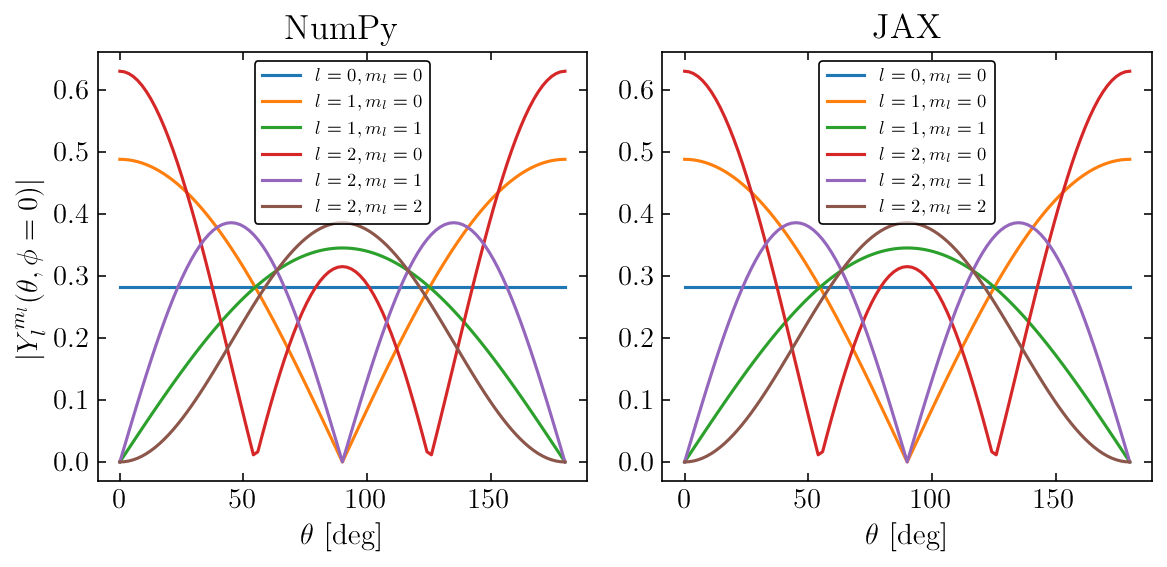

In [22]:
# Spherical harmonics as a function of \theta for several l and m_l

# \theta values
ntot_theta = 101
phi_numpy = 0.0
theta_numpy = np.linspace(0, np.pi, ntot_theta)
theta_jax = jnp.linspace(0, np.pi, ntot_theta)
phi_jax = jnp.zeros_like(theta_jax)

# Loop over quantum numbers and add to plot
f, axs = plt.subplots(1, 2, figsize=(8,4))
for i, qn in enumerate(quantum_numbers):
    
    l, m_l = qn
    ylm_label = rf"$l = {l:d}, m_l = {m_l:d}$"
    ylm_numpy = sph_harm_scipy(m_l, l, phi_numpy, theta_numpy)
    ylm_jax = sf.ylm(theta_jax, phi_jax, l, m_l)
    
    axs[0].plot(np.degrees(theta_numpy), np.abs(ylm_numpy), label=ylm_label)
    axs[1].plot(jnp.degrees(theta_jax), jnp.abs(ylm_jax), label=ylm_label)

axs[0].set_xlabel(r"$\theta$ [deg]")
axs[1].set_xlabel(r"$\theta$ [deg]")
axs[0].set_ylabel(r"$|Y_l^{m_l}(\theta,\phi=0)|$")
axs[0].legend(loc='upper center', fontsize=9)
axs[1].legend(loc='upper center', fontsize=9)
axs[0].set_title('NumPy')
axs[1].set_title('JAX')
f.tight_layout();

In [23]:
theta, phi, l, m_l = jnp.pi / 4, 0.0, 0, 0
print(sf.ylm(theta, phi, l, m_l))

[0.28209479+0.j]


In [24]:
class Test:
    
    def __init__(self):
        self.sf = SpecialFunctions(4)
    
    @partial(jit, static_argnums=(0,))
    def compute_ylm(self, theta, phi, l, m_l):
        return self.sf.ylm(theta, phi, l, m_l)
    
    @partial(jit, static_argnums=(0,))
    def vmap_compute_ylm(self, theta_array, phi_array, l, m_l):
        return vmap(self.compute_ylm, in_axes=(0, 0, None, None))(
            theta_array, phi_array, l, m_l
        )

    @partial(jit, static_argnums=(0,))
    def compute_ylm_2(self, theta, phi, l, m_l):
        ntot = theta.size
        l_array = jnp.repeat(l, ntot)
        m_l_array = jnp.repeat(m_l, ntot)
        return sph_harm(m_l_array, l_array, phi, theta, n_max=10)
    
    @partial(jit, static_argnums=(0,))
    def vmap_compute_ylm2(self, theta_grid, phi_grid, l, m_l):
        return vmap(self.compute_ylm_2, in_axes=(0, 0, None, None))(
            theta_grid, phi_grid, l, m_l
        )

t = Test()
print(t.compute_ylm(theta, phi, l, m_l))

# This isn't working!
# print(t.vmap_compute_ylm(theta_jax, phi_jax, l, m_l))
print(t.compute_ylm_2(theta_jax, phi_jax, l, m_l).shape)

dummy_array = jnp.zeros(5)
theta_grid, _ = jnp.meshgrid(theta_jax, dummy_array, indexing='ij')
phi_grid = jnp.zeros_like(theta_grid)
t_grid = t.vmap_compute_ylm2(theta_grid, phi_grid, l, m_l)
print(t_grid.shape)

[0.28209479+0.j]
(101,)
(101, 5)


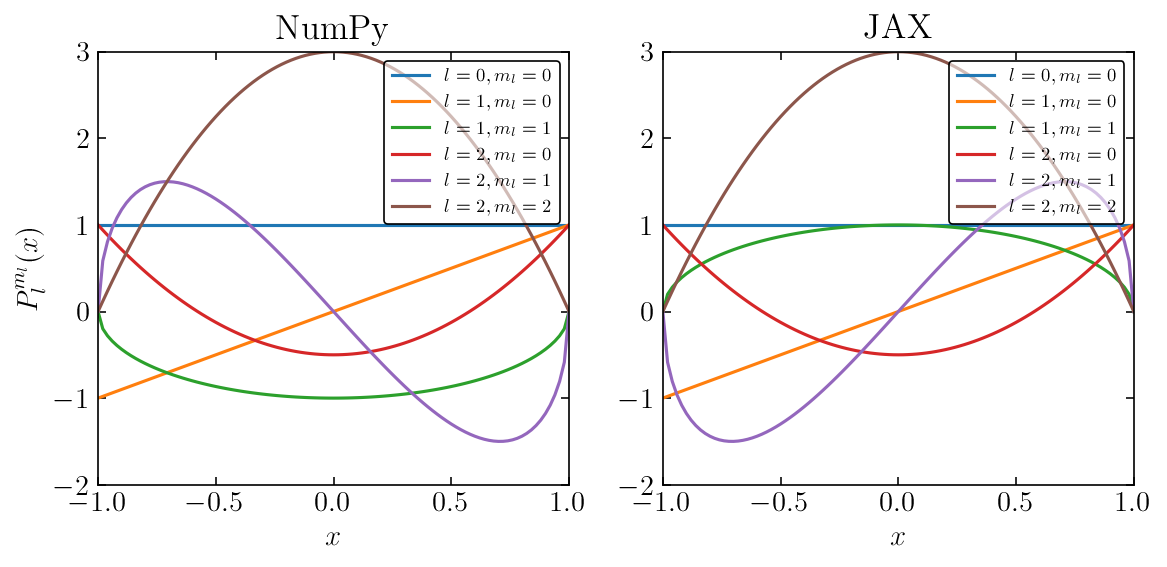

In [25]:
# Legendre polynomials as a function of \cos(\theta) = x
# Note, SciPy uses acoustic's convention of P_L^M(x)

xlim = (-1, 1)
ylim = (-2, 3)

# x values
ntot_x = 101
x_numpy = np.linspace(-1, 1, ntot_x)
x_jax = jnp.linspace(-1, 1, ntot_x)
theta_jax = jnp.arccos(x_jax)

# Loop over quantum numbers and add to plot
f, axs = plt.subplots(1, 2, figsize=(8,4))
for i, qn in enumerate(quantum_numbers):
    
    l, m_l = qn
    plm_label = rf"$l = {l:d}, m_l = {m_l:d}$"
    plm_numpy = lpmv(m_l, l, x_numpy)
    plm_jax = sf.plm(theta_jax, l, m_l)
    
    axs[0].plot(x_numpy, plm_numpy, label=plm_label)
    axs[1].plot(x_jax, plm_jax, label=plm_label)

axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[0].set_xlabel(r"$x$")
axs[1].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$P_l^{m_l}(x)$")
axs[0].legend(loc='upper right', fontsize=9)
axs[1].legend(loc='upper right', fontsize=9)
axs[0].set_title('NumPy')
axs[1].set_title('JAX')
f.tight_layout();

### Potentials

In [26]:
# Initialization of potential
kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
potential = Potential(kvnn, kmax, kmid, ntot)

In [27]:
# Storing the potential in big JAX arrays
print(potential.uncoupled_potentials.shape)
print(potential.coupled_potentials.shape)

(6, 120, 120)
(3, 240, 240)


In [28]:
# Loading potential from data for uncoupled-channel
L, S, J = 0, 0, 0
V_1S0 = potential.get_uncoupled_potential(L, S, J)
print(V_1S0.shape)

(120, 120)


In [29]:
# Loading potential from data for coupled-channel
L, S, J = 0, 1, 1
V_3S1 = potential.get_coupled_potential(J)
print(V_3S1.shape)

(240, 240)


### $T$-matrix

In [30]:
tmatrix = TMatrix(kvnn, kmax, kmid, ntot)
pp = 0.5

In [31]:
# Computing T-matrix in uncoupled channel
L, Lp, S, J = 0, 0, 0, 0
T_1S0 = tmatrix.compute(pp, L, Lp, S, J)
print(T_1S0.shape)

(121, 121)


In [32]:
# Computing T-matrix in coupled channel
L, Lp, S, J = 0, 2, 1, 1
T_3S1_3D1 = tmatrix.compute(pp, L, Lp, S, J)
print(T_3S1_3D1.shape)

(121, 121)


### $\lvert \Delta \psi(k) \rvert$

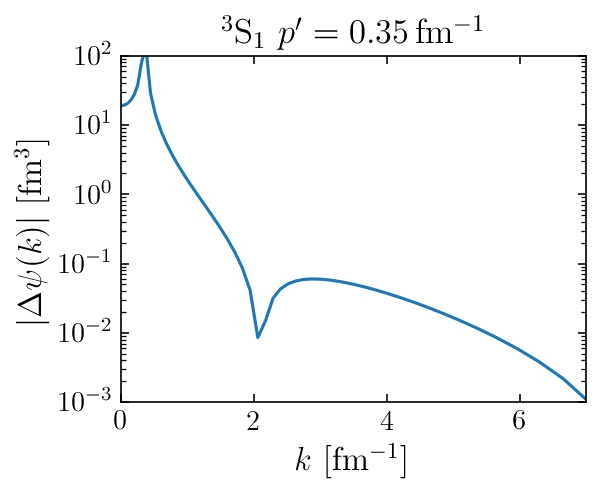

In [33]:
pp = 0.35
plot_delta_psi(pp, x_limits=(0,7), y_limits=(1e-3,1e2))

### Form factors

In [34]:
ff = FormFactors()
Q2_array = jnp.arange(0.1, 1.1, 0.1)
GEp_array = ff.GEp(Q2_array)
GEn_array = ff.GEn(Q2_array)
for i, j, k in zip(Q2_array, GEp_array, GEn_array):
    print(i, j, k)

0.1 0.7515092988873647 0.03229
0.2 0.5877777997826349 0.04462
0.30000000000000004 0.4726511969414762 0.04925
0.4 0.38808049103157205 0.05049
0.5 0.32392066047401136 0.05011
0.6000000000000001 0.2740017469844414 0.04894
0.7000000000000001 0.23435921130727827 0.04736
0.8 0.20234305600631544 0.0456
0.9 0.17611119825624008 0.04376
1.0 0.15435207209055782 0.04192


### Deuteron wave function

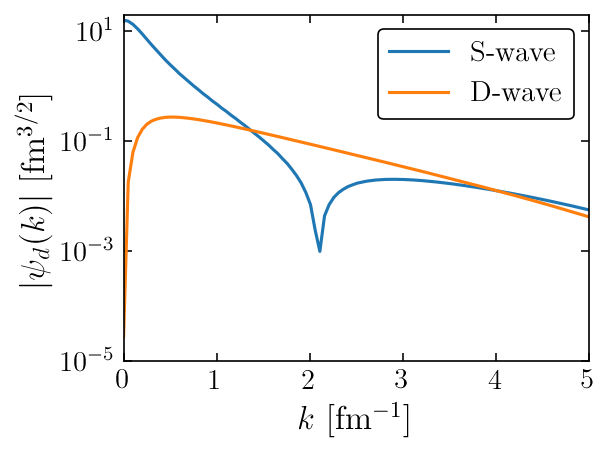

In [35]:
plot_deuteron_wf()

### Impulse approximation

In [36]:
thetap_array = jnp.linspace(0.01, 179.9, 100)

In [37]:
Ep = 100
q = jnp.sqrt(10)
plot_fL_wrt_thetap(Ep, thetap_array, q, x_limits=(0,180), y_limits=(0,8))

IndexError: tuple index out of range

In [ ]:
Ep = 10
q = 2
plot_fL_wrt_thetap(Ep, thetap_array, q, x_limits=(0,180), y_limits=(0,0.15))

In [ ]:
Ep = 30
q = 4
plot_fL_wrt_thetap(Ep, thetap_array, q, x_limits=(0,180), y_limits=(0,0.0025))

In [ ]:
Ep_array = np.linspace(10, 110, 100)
thetap = 15.0
plot_fL_quasifree_ridge(Ep_array, thetap, x_limits=(10,115), y_limits=(0,6), calc=True)
# plot_fL_quasifree_ridge(Ep_array, thetap, x_limits=(10,115), y_limits=(0,6))

In [38]:
import jax
import jax.numpy as jnp
from jax.scipy.special import sph_harm

@jax.jit
def compute_sph_harm(l, m, theta, phi):
    # Ensure inputs are JAX arrays
    l = jnp.asarray(l, dtype=jnp.int32)
    m = jnp.asarray(m, dtype=jnp.int32)
    theta = jnp.asarray(theta, dtype=jnp.float32)
    phi = jnp.asarray(phi, dtype=jnp.float32)

    # Compute spherical harmonic
    result = sph_harm(m, l, theta, phi)
    return result

# Example usage
l, m = 2, 1
theta, phi = 1.0, 0.5  # in radians
result = compute_sph_harm(l, m, theta, phi)
print(result)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[].
The `n_max` argument of `jnp.scipy.special.sph_harm` must be statically specified to use `sph_harm` within JAX transformations.
The error occurred while tracing the function compute_sph_harm at /var/folders/4c/p53tldwd6f76zfs85vnyk3qr0000gn/T/ipykernel_30244/2724731209.py:5 for jit. This concrete value was not available in Python because it depends on the value of the argument l.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError